<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>


# <a name="0">Machine Learning University</a>
## <a name="0">Lab4b: Tree of Thoughts (ToT)</a>

This notebook introduces the Tree of Thoughts prompting strategy, that guides generative models for text to generate, evaluate, expand on, and decide among multiple solutions. The process is similar to how humans solve problems by evaluating various potential solutions before deciding on the most promising one.

1. <a href="#1">Import libraries</a>
2. <a href="#2">Set up Bedrock for inference</a>
3. <a href="#3">Tree of Thoughts (ToT)</a>
    - <a href="#31">Creative writing task</a>
    - <a href="#32">Prompts and custom class to run the creative writing task</a>
    - <a href="#33">Baseline 1: Standard prompting</a>
    - <a href="#34">Baseline 2: Chain-of-thought prompting</a>
    - <a href="#35">Tree-of-thought prompting</a>
4. <a href="#4">Evaluation of results</a>
5. <a href="#5">Quizzes</a>
    
Please work top to bottom of this notebook and don't skip sections as this could lead to error messages due to missing code.

---

<br/>
You will be presented with coding activities to check your knowledge and understanding throughout the notebook whenever you see the MLU robot:

<img style="display: block; margin-left: auto; margin-right: auto;" src="../mlu_utils/activity.png" alt="Activity" width="125"/>

### <a name="1">1. Import libraries</a>
(<a href="#0">Go to top</a>)

Let's start by installing all required packages as specified in the `requirements.txt` file and importing several libraries.

In [ ]:
%%capture
!pip install -q -r ../requirements.txt

In [ ]:
import sys
sys.path.append('..')

import boto3
import re
import random
import numpy as np
import textwrap
from collections import Counter

from langchain.llms.bedrock import Bedrock
from langchain.prompts import PromptTemplate

from igraph import Graph
import plotly.graph_objects as go

from IPython.display import Markdown, display

%load_ext autoreload
%autoreload 2
from mlu_utils.utils import *

### <a name="2">2. Set up Bedrock for inference</a>
(<a href="#0">Go to top</a>)

To get started, set up Bedrock and instantiate an active `bedrock-runtime` to query LLMs. 

Let us define a custom function to run inference with Bedrock-hosted models. The code below leverages [LangChain's Bedrock integration](https://python.langchain.com/docs/integrations/llms/bedrock) and allows to use Bedrock-hosted models.


Next, use Bedrock for inference to test everything works as expected:

In [ ]:
# Example model prompting

MODEL = "mistral.mistral-7b-instruct-v0:2"
TEMP = 0.8
SAMPLES = 2

greeting_prompt = "<s>[INST]How are you doing?[/INST]"
Markdown(generate_outputs(greeting_prompt, MODEL, TEMP, max_tokens=128, n=5)[0])

### <a name="3">3. Tree of Thoughts (ToT)</a>
(<a href="#0">Go to top</a>)

The Tree of Thoughts (ToT) framework was proposed in 2023 in the following two papers:
* [Tree of Thoughts: Deliberate Problem Solving with Large Language Models](https://arxiv.org/abs/2305.10601), Yao et al. (2023)
* [Large Language Model Guided Tree-of-Thought](https://arxiv.org/abs/2305.08291), Long (2023)

ToT is motivated by the difficulties that LLMs prompted with simple techniques encounter when trying to solve complex tasks that require exploration or strategic lookahead. ToT generalizes over Chain of Thought (CoT) and encourages exploration over "thoughts" that serve as intermediate steps for general problem solving with LLMs. CoT prompting samples thoughts sequentially, but ToT prompting follows a tree-branching technique. With the ToT technique, the LLM can consider multiple paths instead of one sequential path. ToT is an especially effective method for tasks that involve important initial decisions, strategies for the future, and exploration of multiple solutions. 

Below you will see how to use a Bedrock-hosted LLM to solve a task using the ToT technique. You will compare the results with those given by standard and CoT prompts.


<div>
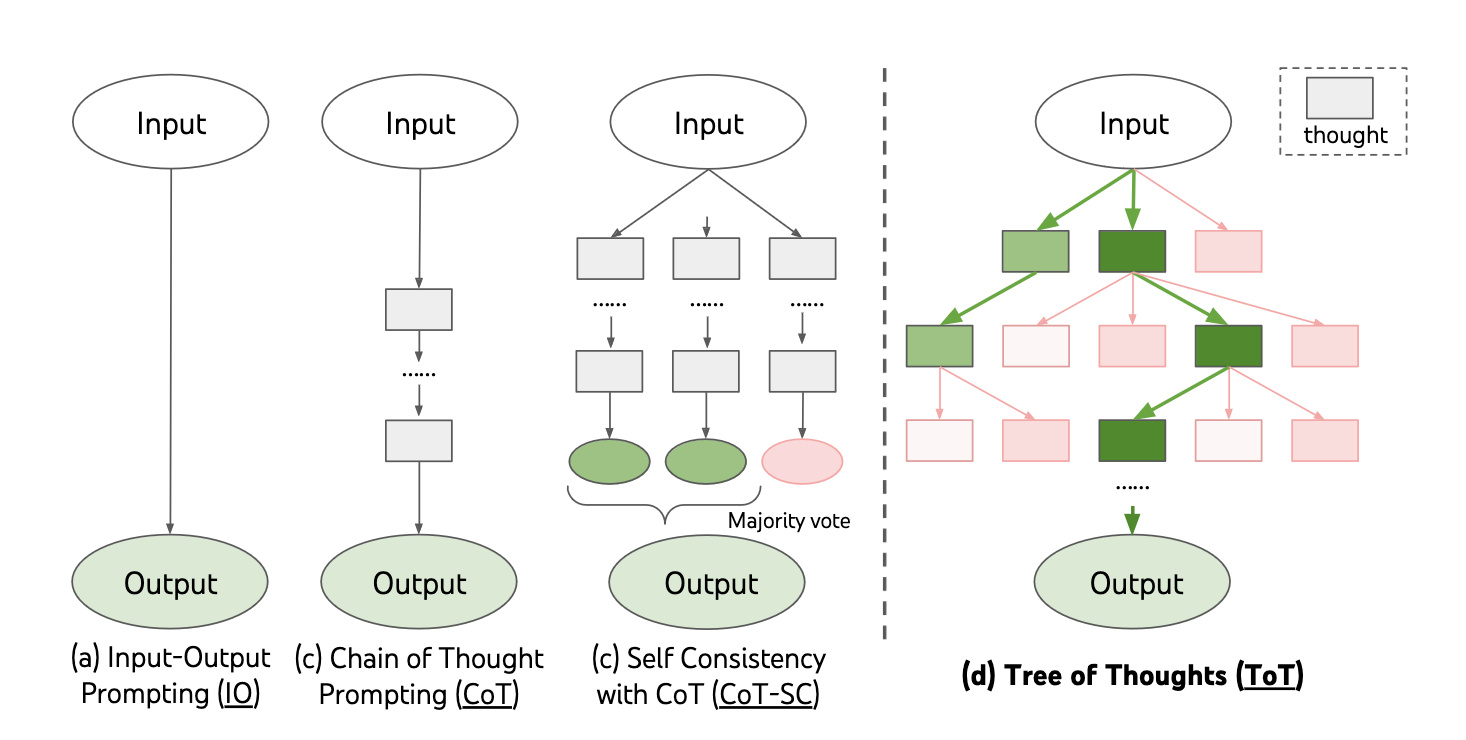
</div>


#### <a name="31">3.1. Creative writing task</a>
(<a href="#0">Go to top</a>)

We will build on the creating writing exercise shown in Yao et al. which prompts the LLM to write a coherent passage of a few paragraphs constrained to some fixed sentences. For baselines they use zero-shot standard and CoT prompts. While the former prompts the LLM to directly generate a coherent passage given input constraints, the latter prompts to first make a brief plan then write the passage, i.e. **the plan serves as the intermediate thought step.** 

For ToT we will build a tree with depth 2 (and only 1 intermediate thought step). The LLM is prompted to generate `k` plans and vote for the most promising one, then similarly generate `k` passages based on the best plan to finally vote for the best one. A simple zero-shot vote prompt is used to sample `j` votes at both steps. The LLM will be tasked to write a customer press release.

In [ ]:
# Amazon Local Gift Cards PR
title = "Amazon introduces Local Gift Cards"
start = "Gift cards are consistently among the most sought after gifts year after year."
mid = '''"Happy Anniversary"'''
end = '''"And we'll continue to work towards our vision of allowing our customers to find and purchase any gift card they need."'''

input_data = (title, start, mid, end)

#### <a name="32">3.2. Prompts and custom class to run the creative writing task</a>
(<a href="#0">Go to top</a>)

For this exercise we will be using several prompts, that we keep in a separate file `prompts.py`.

In [ ]:
# We load all prompts from a separate file prompts.py

from mlu_utils.prompts import (
    standard_prompt_template,
    cot_prompt_template,
    plan_prompt_template,
    vote_plan_prompt_template,
    vote_passage_prompt_template,
    score_coherency_prompt_template,
    compare_prompt_template,
)

To facilitate running experiments, we have created a custom class that implements ToT and allows to generate outputs with standard, CoT, and ToT prompting techniques. 

The code below implements all needed methods. **You don't need to understand every detail**. Later in the notebook we will use the class step by step to run the ToT approach.

In [ ]:
BASELINES = ["standard", "cot"]
VOTES = ["vote_plan", "vote_passage"]
PASSAGE_STR = "Passage:"
PLAN_STR = "Plan:"

TEMPLATES = {
    "standard": standard_prompt_template,
    "cot": cot_prompt_template,
    "vote_plan": vote_plan_prompt_template,
    "vote_passage": vote_passage_prompt_template,
}


class TextTaskToT:
    """
    Class to run ToT for creative writing
    """

    def __init__(self, input_data, model, temperature):
        self.title, self.start, self.mid, self.end = input_data
        self.model = model
        self.temperature = temperature
        self.votes_outputs = {}
        self.best_choice = {}

    def wrap_prompt(self, method, extra_args=None):
        """
        Returns different prompts used in this task
        Supported methods: standard, cot, plan, vote_plan, vote_passage
        """
        if method in BASELINES:
            prompt = PromptTemplate.from_template(TEMPLATES[method]).format(
                title=self.title, start=self.start, mid=self.mid, end=self.end
            )

        if method == "plan":
            prompt = PromptTemplate.from_template(plan_prompt_template).format(
                plan=extra_args,
                title=self.title,
                start=self.start,
                mid=self.mid,
                end=self.end,
            )

        if method in VOTES:
            enumerated_choices = ""
            for i, choice in enumerate(extra_args, 1):
                enumerated_choices += f"Choice {i}: \n{choice}\n\n"

            prompt = PromptTemplate.from_template(TEMPLATES[method]).format(
                enumerated_choices=enumerated_choices.strip()
            )
        return prompt

    def generate_tot_thoughts(self, n_branches):
        """
        Generate n_branches thoughts to start the tree of thoughts
        """
        # CoT prompt to generate the branches for ToT
        prompt = self.wrap_prompt("cot")
        # Stop generating in "Passage:" since we want the plans only
        thoughts = generate_outputs(
            prompt,
            self.model,
            self.temperature,
            stop_sequences=[PASSAGE_STR],
            n=n_branches,
        )
        # Ensure that the thoughts are clean of "Passage:" and "Plan:" markers
        thoughts = [self.sanitize_passage(t, PLAN_STR, position=1) for t in thoughts]
        thoughts = [self.sanitize_passage(t, PASSAGE_STR, position=0) for t in thoughts]
        return thoughts

    def vote_tot_alternatives(self, method, choices, n_rounds_vote):
        """
        Choose best alternative by voting (majority vote)
        """
        # method is "vote_plan" to choose among thoughts or "vote_passage" to choose among passages
        vote_prompt = self.wrap_prompt(method, choices)
        # Store votes outputs for later inspection
        self.votes_outputs[method] = generate_outputs(
            vote_prompt, self.model, self.temperature, n=n_rounds_vote
        )
        votes = [self.extract_vote(vote_out) for vote_out in self.votes_outputs[method]]
        votes_ctr = Counter(votes)
        print(votes_ctr)
        majority_vote = votes_ctr.most_common(1)[0][0]
        if majority_vote is None:
            majority_vote = 0
        # Majority vote determines best choice
        print(f"choices :: {choices}")
        self.best_choice[method] = choices[majority_vote]
        return self.best_choice[method], majority_vote

    def make_tot_passage(self, n_branches, n_rounds_vote):
        """
        Run ToT method end-to-end
        """
        print(f"--- Generating {n_branches} plans...")
        self.thoughts = self.generate_tot_thoughts(n_branches)
        print(f"--- Voting for most promising plan in {n_rounds_vote} rounds...")
        best_plan, best_plan_index = self.vote_tot_alternatives(
            "vote_plan", self.thoughts, n_rounds_vote
        )
        print(f"--- Generating {n_branches} passages from most promising plan...")
        prompt_plan = self.wrap_prompt("plan", best_plan)
        passages = generate_outputs(
            prompt_plan, self.model, self.temperature, n=n_branches
        )
        print(f"--- Voting for most coherent passage in {n_rounds_vote} rounds...")
        best_passage, best_package_index = self.vote_tot_alternatives(
            "vote_passage", passages, n_rounds_vote
        )
        best_passage = self.sanitize_passage(best_passage, PASSAGE_STR, position=1)
        print("Done.\n")
        return best_passage

    def make_passages(self, method, n=1, n_branches=5, n_rounds_vote=3):
        """
        Wrapper to generate passages with the three methods
        """
        if method in BASELINES:
            prompt = ttt.wrap_prompt(method)
            passages = generate_outputs(prompt, self.model, self.temperature, n=n)
            passages = [
                self.sanitize_passage(p, PASSAGE_STR, position=1) for p in passages
            ]

        if method == "tot":
            passages = []
            for i in range(n):
                passages.append(self.make_tot_passage(n_branches, n_rounds_vote))

        return passages

    @staticmethod
    def sanitize_passage(passage, string_to_clean, position):
        """
        Util function to remove unwanted markers in text
        """
        # position is 0 if we keep text before, 1 if we keep text after
        if string_to_clean in passage:
            passage = passage.split(string_to_clean)[position].strip()
        return passage

    @staticmethod
    def extract_vote(vote_output: str) -> int:
        """
        Parser to extract the best choice when the LLM is voting
        """
        pattern = r".*best choice is (\d+).*"
        match = re.match(pattern, vote_output, re.DOTALL)
        vote = None
        if match:
            vote = int(match.groups()[0]) - 1
        return vote

#### <a name="33">3.3. Baseline 1: Standard prompting</a>
(<a href="#0">Go to top</a>)

We will use [Mistral model](https://aws.amazon.com/bedrock/mistral/) hosted in Bedrock to generate passages. Let's start by generating a passage with the standard prompt. 

In [ ]:
MODEL = "mistral.mistral-7b-instruct-v0:2"
TEMP = 0.75

ttt = TextTaskToT(input_data, MODEL, TEMP)

In [ ]:
display(Markdown(ttt.wrap_prompt("standard")))
display(Markdown("---"))
standard_passage = ttt.make_passages("standard")[0]
display(Markdown(standard_passage))

#### <a name="34">3.4. Baseline 2: Chain-of-thought prompting</a>
(<a href="#0">Go to top</a>)


Let's continue with a CoT prompt that asks the LLM to first produce a plan ("thought") before writing the passage.

In [ ]:
display(Markdown(ttt.wrap_prompt("cot")))
display(Markdown("---"))
cot_passage = ttt.make_passages("cot")[0]
display(Markdown(cot_passage))

#### <a name="35">3.5. Tree-of-thought prompting</a>
(<a href="#0">Go to top</a>)

Finally let's use Tree of Thoughts to improve on this passage generation. The system will undergo the following steps: 
- produce `k` plans as "thoughts" 
- vote for the most promising one
- generate `n` passages using the most promising thought
- vote for the most coherent passage

Let's show a step by step example using `k=3` branches for the number of thoughts. 

1. First we generate the 3 thoughts. 
2. We then ask the model to vote for the most promising using a simple vote prompt (see `vote_plan_prompt_template` in `prompts.py`).
3. Next we generate multiple passages from the best plan. 
4. Finally the system is again tasked with voting for the "best" passage, understood as the most coherent. 

The following cell takes 1-2 minutes to run.

In [ ]:
# Generate 3 thoughts
thoughts = ttt.generate_tot_thoughts(n_branches=3)

# Vote for the best plan
best_plan, best_plan_index = ttt.vote_tot_alternatives("vote_plan", thoughts, n_rounds_vote=3)

# Generate passages with the best plan
prompt_plan = ttt.wrap_prompt("plan", best_plan)
candidate_passages = generate_outputs(prompt_plan, ttt.model, ttt.temperature, n=3)

# Vote for the best package
best_passage, best_passage_index = ttt.vote_tot_alternatives(
    "vote_passage", candidate_passages, n_rounds_vote=3
)
Markdown(best_passage)

In [ ]:
candidate_passages

#### Visualize ToT logic

Let's plot a tree to help us visualize the steps followed by the ToT method. We will use `igraph` and `plotly` for that. 

**You don't need to understand every detail of the plotting code.** Here's some [plotly documentation](https://plotly.com/python/tree-plots/) if you're interested in using the library yourself. 

In [ ]:
def flatten(matrix):
    """ Function to flatten a list of lists """
    return [item for row in matrix for item in row]


def wrap_text(text, width=40):
    """ Function to wrap text into a fixed size box for display """
    text = "\n".join(
        [
            "\n".join(
                textwrap.wrap(
                    line, width, break_long_words=False, replace_whitespace=False
                )
            )
            for line in text.splitlines()
            if line.strip() != ""
        ]
    )
    return text.replace("\n", "<br>")


# Hard-coded to this example with k=3 thoughts
nr_vertices = 7
best_plan_index_tree = 1 + best_plan_index
best_passage_index_tree = 4 + best_passage_index
edges = [(0, 1), (0, 2), (0, 3), (best_plan_index_tree, 4), (best_plan_index_tree, 5), (best_plan_index_tree, 6)]
G = Graph(edges=edges)
lay = G.layout('rt', root=[0])

# Coordinates of nodes and edges
Xn, Yn = zip(*lay.coords)
Yn = [-y for y in Yn]
Xe = flatten([(lay.coords[edge[0]][0], lay.coords[edge[1]][0], None) for edge in edges])
Ye = flatten([(-lay.coords[edge[0]][1], -lay.coords[edge[1]][1], None) for edge in edges])


# Put the proper labels into the nodes of the tree
labels = [
    "Tree-of-Thoughts root",
    wrap_text(thoughts[0]),
    wrap_text(thoughts[1]),
    wrap_text(thoughts[2]),
    wrap_text(candidate_passages[0].split("\nPlan")[1], width=80),
    wrap_text(candidate_passages[1].split("\nPlan")[1], width=80),
    wrap_text(candidate_passages[2].split("\nPlan")[1], width=80)
]

# Assemble everything and plot
lo = go.Layout(
    autosize=False, width=1200, height=400,
    xaxis=go.layout.XAxis(linecolor="white", linewidth=1, mirror=True, showgrid=False, showticklabels=False),
    yaxis=go.layout.YAxis(linecolor="white", linewidth=1, mirror=True, showgrid=False, showticklabels=False),
    margin=go.layout.Margin(l=0, r=0, b=0, t=50, pad=0),
)

fig = go.Figure(layout=lo)
fig.update_layout(plot_bgcolor="white", showlegend=False, title="Tree-of-thoughts with k=3 and depth=2")
# Add edges
fig.add_trace(
    go.Scatter(x=Xe, y=Ye, mode="lines", line=dict(color="lightgray", width=2), hoverinfo="none",)
)
# Add nodes
fig.add_trace(
    go.Scatter(x=Xn, y=Yn, mode="markers", name="",
        marker=dict(
            symbol="circle-dot",
            size=18,
            color="royalblue",
            line=dict(color="royalblue", width=1),
        ),
        text=labels, hoverinfo="text", opacity=0.8,
    )
)
# Update with best alternatives
bestXn = [Xn[best_plan_index_tree], Xn[best_passage_index_tree]]
bestYn = [Yn[best_plan_index_tree], Yn[best_passage_index_tree]]
bestlabels = [labels[best_plan_index_tree], labels[best_passage_index_tree]]
fig.add_trace(
    go.Scatter(x=bestXn, y=bestYn, mode="markers", name="",
        marker=dict(
            symbol="circle-dot",
            size=18,
            color="seagreen",
            line=dict(color="seagreen", width=1),
        ),
        text=bestlabels, hoverinfo="text", opacity=0.8,
    )
)

<div style="border: 4px solid coral; text-align: center; margin: auto; padding-left: 50px; padding-right: 50px">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">You can inspect the reasons why the system voted for one or the other thoughts and passages. </p>
    <p style=" text-align: center; margin: auto;">Try looking into <code>ttt.votes_outputs</code>. You will find keys <code>vote_plan</code> and <code>vote_passage</code> containing the analysis that yielded the best options. Majority vote decided the output. Do you agree with the decision made by the system?</p>
    <br>
</div>


In [ ]:
############## CODE HERE ####################



############## END OF CODE ##################

#### Run ToT end-to-end

We can now generate a ToT passage using the wrapper function. We will use `k=5` for the number of thoughts and `j=3` for the number of times we ask the LLM to vote in both levels of the tree. 

In [ ]:
tot_passage = ttt.make_passages("tot", n_branches=5, n_rounds_vote=3)[0]
display(Markdown(tot_passage))

### <a name="4">4. Evaluation of results</a>
(<a href="#0">Go to top</a>)

A key aspect of LLM usage is the evaluation of its results. In this example we will use a second LLM, Mistral 7b model, to assess the coherency of pairs of passages. Following Yao et al. we implement two methods: 

- ask the evaluator LLM to provide coherency score from 1 to 10
- ask the evaluator LLM to compare two passages and assess which one is more coherent. 

To faciliate experimentation, we provide a class for evaluation below that implements both methods.

In [ ]:
class EvaluateToT:
    """
    Class to evaluate ToT against baselines
    """

    def __init__(self, model, temperature):
        self.model = model
        self.temperature = temperature

    def compare_passages(self, passage1, passage2, n_rounds=1):
        """
        Ask LLM to compare passages and decide which one is more coherent
        """
        compare_prompt = PromptTemplate.from_template(compare_prompt_template).format(
            passage1=passage1, passage2=passage2
        )
        comparisons = generate_outputs(
            compare_prompt, self.model, self.temperature, n=n_rounds
        )
        return comparisons

    def score_passages(self, passage, n_rounds=1):
        """
        Ask LLM to score the coherency of a passage from 1 to 10
        """
        score_coherency_prompt = PromptTemplate.from_template(
            score_coherency_prompt_template
        ).format(passage=passage)
        scoring = generate_outputs(
            score_coherency_prompt, self.model, self.temperature, n=n_rounds
        )
        return scoring

Below are the passages generated by the three methods:

In [ ]:
passages = {"standard": standard_passage, "cot": cot_passage, "tot": tot_passage}

for method, passage in passages.items():
    display(Markdown(f"### Passage with {method} prompting:"))
    display(Markdown(passage))
    display(Markdown("---"))

### Evaluating coherence via LLM scoring.

Let's instantiate the evaluator with the Mistral 7b model. For the first evaluation task, we prompt the model to score the coherency of each passage. 

In [ ]:
MODEL_EVAL = "amazon.titan-text-premier-v1:0"
TEMP_EVAL = 0.75

ett = EvaluateToT(MODEL_EVAL, TEMP_EVAL)

In [ ]:
for method in passages.keys():
    display(Markdown(f"### {method}"))
    display(Markdown((ett.score_passages(passages[method])[0])))
    display(Markdown(("---")))

### Evaluating coherence via pair comparison.

For the second evaluation task, we construct pairs of passages and ask the evaluator LLM to choose the more coherent of the two. To double check consistency of the LLM as evaluator, we test the coherency of a passage with itself (it should be equally coherent) and we also flip the order of the evaluated passages (theoretically the LLM should not care about the order, but in practice we observe a certain tendency to prefer the first appearing passage).

In [ ]:
pairs = [
    ("standard", "standard"),
    ("tot", "tot"),
    ("standard", "cot"),
    ("cot", "standard"),
    ("standard", "tot"),
    ("tot", "standard"),
    ("cot", "tot"),
    ("tot", "cot"),
]

In [ ]:
for pair in pairs:
    passage1, passage2 = pair
    display(Markdown((f"### 1. {passage1}\t2. {passage2}")))
    display(Markdown((ett.compare_passages(passages[passage1], passages[passage2])[0])))
    display(Markdown(("---")))

### Conclusion

We have implemented the Tree-of-Thoughts prompting approach as introduced in Yao et al. (2023) and have applied it to the same type of creative writing task showcased there (the other 2 are solving a mini crossword and the mathematical reasoning challenge Game of 24). For creative writing, the generation of plans that serve as thoughts allow the system to consider several paths and choose the most promising one. 

Notice that due to the variability in the generated outputs, and the fact that LLMs as evaluators tend to prefer the choice presented as first option, it is not always possible to observe a clear superiority of the ToT approach with respect to the baselines. The ToT paper presents results from multiple runs using OpenAI models and are able to demonstrate that ToT produces improved results than standard and CoT prompting. 

<div style="border: 4px solid coral; text-align: center; margin: auto; padding-left: 50px; padding-right: 50px">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/activity.png" alt="Activity" width="100" /> </p>
    <p style=" text-align: center; margin: auto;"><b>Well done on completing the lab. Now it's time for you to get creative.</b></p>
    <p style=" text-align: center; margin: auto;">Try changing the input data to prompt the model to produce passages based on different data. You can also modify the model id and temperature settings to explore the variability of the results.</p>
    <br>
</div>


In [ ]:
############## CODE HERE ####################



############## END OF CODE ##################

---
### <a name="5">Quiz Questions</a>

Well done on completing the lab! Now, it's time for a brief knowledge assessment.

<div style="border: 4px solid coral; text-align: center; margin: auto;">
    <h2><i>Try it Yourself!</i></h2>
    <br>
    <p style="text-align:center;margin:auto;"><img src="../mlu_utils/challenge.png" alt="Challenge" width="100" /> </p>
    <p style=" text-align: center; margin: auto;">Answer the following questions to test your understanding of topics.</p>
    <br>
</div>

In [ ]:
import sys
sys.path.append('..')
from mlu_utils.quiz_questions import *

lab4b_question1

# Thank you!

<p style="padding: 10px; border: 1px solid black;">
<img src="../mlu_utils/MLU-NEW-logo.png" alt="drawing" width="400"/> <br/>